In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import numpy as np #    
import matplotlib
import tkinter

import pylab # модуль для построения графиков
import matplotlib.pyplot as plt #                                                              +                        
import cv2
import ipywidgets as widgets
from PIL import ImageEnhance
from PIL import Image # отрисовка изображений

from skimage import io, color
from skimage import util
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
import matplotlib.image as mpimg 
import os
from tensorflow.keras.preprocessing import image

In [5]:
import pydicom
from skimage.transform import rotate

# 1. Общие действия

### 1.1 количество снимков в полученной папке unhealthy

In [6]:
def count_photos(folder_path):
    photo_extensions = ['.dcm']
    count = 0
    for file_name in os.listdir(folder_path):
        _, extension = os.path.splitext(file_name)
        if extension.lower() in photo_extensions:
            count += 1
    return count

folder_path = 'unhealthy'
photo_count = count_photos(folder_path)
print(photo_count)

1113


### 1.2 анализ файлов в папке 'unhealthy'

#### 1.2.1 серия 0002

In [7]:
# Загрузка файла DICOM
dcm_file = "unhealthy/IMG-0002-00808.dcm"
dcm_data = pydicom.dcmread(dcm_file)

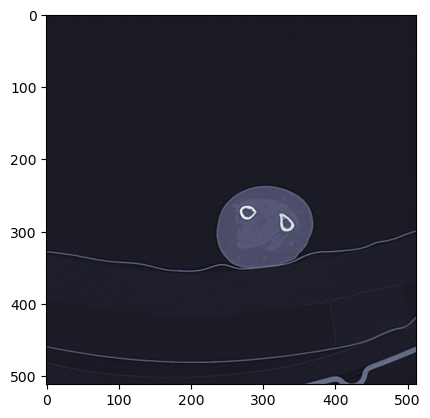

In [8]:
# Конвертация в изображение PIL
image = Image.fromarray(dcm_data.pixel_array)

# Отображение изображения
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

#### 1.2.2 серия 0003

In [9]:
# Загрузка файла DICOM
dcm_file = "unhealthy/IMG-0003-00001.dcm"
dcm_data = pydicom.dcmread(dcm_file)

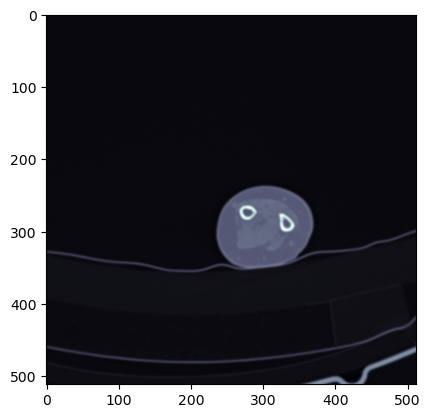

In [10]:
# Конвертация в изображение PIL
image = Image.fromarray(dcm_data.pixel_array)

# Отображение изображения
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

Зеркальный файл и зеркальная серия, удалить

#### УСТАНОВКА НОВЫХ БИБЛИОТЕК

#### БИБЛИОТЕКИ ДЛЯ 3D ВИЗУАЛИЗАЦИИ 'vtk' И 'mayavi'

### 1.3 создание папки "unhealthy1", содержащей только файлы серии 0002 

In [11]:
import shutil

# Директория с исходными DICOM файлами
source_directory = 'unhealthy'
# Директория для файлов серии 0002
destination_directory = 'unhealthy1'

# Создание новой директории, если она не существует
os.makedirs(destination_directory, exist_ok=True)

# Список всех файлов в исходной директории
files = os.listdir(source_directory)

# Фильтрация и копирование файлов серии 0002
for file_name in files:
    if '0002' in file_name:
        source_file = os.path.join(source_directory, file_name)
        destination_file = os.path.join(destination_directory, file_name)
        shutil.copy2(source_file, destination_file)

print("Files from series 0002 have been copied to the new directory.")

Files from series 0002 have been copied to the new directory.


In [12]:
def count_photos(folder_path):
    photo_extensions = ['.dcm']
    count = 0
    for file_name in os.listdir(folder_path):
        _, extension = os.path.splitext(file_name)
        if extension.lower() in photo_extensions:
            count += 1
    return count

folder_path = 'unhealthy1'
photo_count = count_photos(folder_path)
print(photo_count)

819


### 1.4 проверка наличия пиксельных данных и удаление пустых файлов

In [13]:
# Директория с DICOM файлами
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]

print(f"Found {len(files)} DICOM files in the directory.")

Found 819 DICOM files in the directory.


In [14]:
files_without_images = []

for file_name in files:
    file_path = os.path.join(directory, file_name)
    try:
        dcm = pydicom.dcmread(file_path)
        if not hasattr(dcm, 'PixelData'):
            print(f"File {file_name} does not contain image data. Deleting...")
            os.remove(file_path)
            files_without_images.append(file_name)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue

print(f"Removed {len(files_without_images)} files that do not contain image data.")

Removed 0 files that do not contain image data.


# 2. Проверки и преобразования изображений массива

### 2.1 Проверка размеров изображений

Перед визуализацией проверить все ли изображения имеют одинаковые размеры.

In [15]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

In [16]:
# Проверка размеров изображений
sizes = []
for f in files:
    dcm = pydicom.dcmread(os.path.join(directory, f))
    sizes.append(dcm.pixel_array.shape)

In [17]:
unique_sizes = set(sizes)
print(f"Unique image sizes: {unique_sizes}")

if len(unique_sizes) > 1:
    print("Warning: Not all DICOM files have the same size.")

Unique image sizes: {(512, 512)}


### 2.2 Нормализация изображений

Если размеры не совпадают, нормализовать их до одного размера

In [18]:
from skimage.transform import resize

# Выберем минимальные размеры как базовые
base_height, base_width = min(sizes)
# Можно также выбрать максимальные размеры для базовых, чтобы избежать потерь данных
# base_height, base_width = max(sizes)

resized_slices = []
for f in files:
    dcm = pydicom.dcmread(os.path.join(directory, f))
    image = dcm.pixel_array
    if image.shape != (base_height, base_width):
        image_resized = resize(image, (base_height, base_width), anti_aliasing=True)
        image_resized = (image_resized * 65535).astype(np.uint16)  # Приведение к типу данных DICOM
    else:
        image_resized = image
    
    resized_slices.append(image_resized)

volume = np.stack(resized_slices, axis=-1)

### 2.3 Проверка ориентации и позиционирования

DICOM файлы могут содержать информацию о положении и ориентации изображений. Ориентируем изображения по оси Z предварительно сортируя их

In [19]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    return dcm.pixel_array, dcm.ImagePositionPatient

# Читаем все DICOM файлы и получаем их ImagePositionPatient атрибут и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (ось пациента)

volume = np.stack([s[0] for s in slices], axis=-1)

Проверка наличия атрибута: Добавить проверку наличия атрибута ImagePositionPatient перед его использованием.
Использование альтернативных атрибутов: Если ImagePositionPatient отсутствует, упорядочить файлы на основе других атрибутов, таких как InstanceNumber или SliceLocation

In [20]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume = np.stack([s[0] for s in slices], axis=-1)
print(volume.shape)

(512, 512, 819)


# 3. Визуализация по проекцим

### 3.1 Прямая визуализация с исходной контрастностью

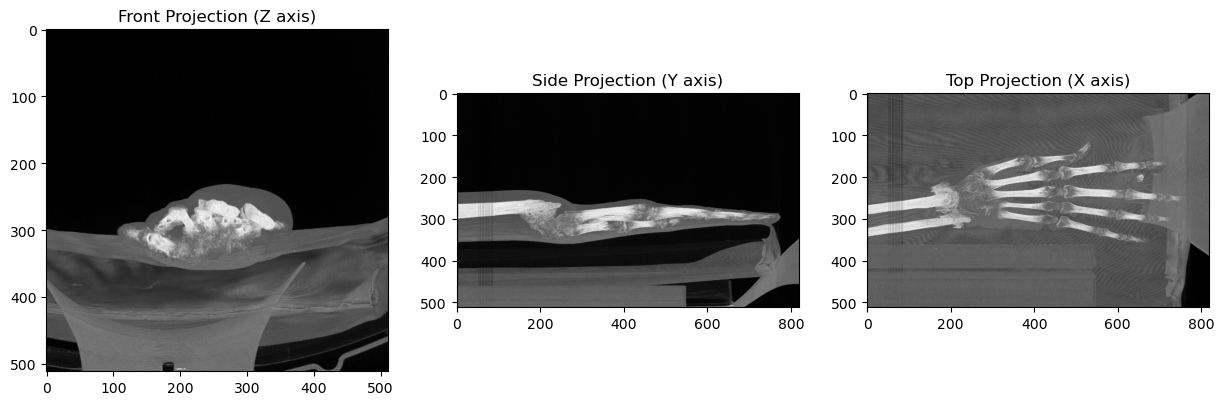

In [21]:
# Front projection (по оси Z)
projection_z = np.max(volume, axis=2)

# Side projection (по оси Y)
projection_y = np.max(volume, axis=1)

# Top projection (по оси X)
projection_x = np.max(volume, axis=0)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_z, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

# 4. Числовые значения в проекциях массива

### 4.1 Top projection (по оси X)

In [22]:
# Top projection (по оси X)
projection_x = np.max(volume, axis=0)

In [23]:
projection_x

array([[8355, 8389, 8374, ..., 8733, 8708, 8686],
       [8317, 8406, 8403, ..., 8660, 8655, 8678],
       [8296, 8339, 8326, ..., 8681, 8712, 8715],
       ...,
       [8649, 8620, 8625, ..., 7257, 7234, 7238],
       [8633, 8628, 8600, ..., 7260, 7249, 7260],
       [8677, 8718, 8675, ..., 7287, 7250, 7262]], dtype=uint16)

In [24]:
print(projection_x.max())
print(projection_x.min())
print(projection_x.mean())

11024
7217
8688.573467548076


In [25]:
projection_x.shape

(512, 819)

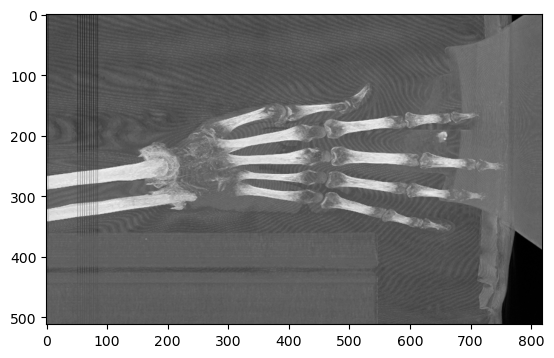

In [26]:
from skimage.transform import rotate

plt.imshow(projection_x,cmap='gray')
plt.show()

### 4.2 Проверка значений в массиве по координатам

In [27]:
projection_x[100][750]

8891

In [28]:
projection_x[500][800]

7252

In [29]:
projection_x[275][5]

10528

### 4.3 Расчёты для преобразования в стандартные значения пикселей

In [30]:
print(projection_x.max())
print(projection_x.min())
print(projection_x.mean())

11024
7217
8688.573467548076


In [31]:
# разность значений
p = projection_x.max() - projection_x.min()
p

3807

In [32]:
# Соотношение значений пикселей
s = int(p / 256 + 1)
s

15

In [33]:
# приведённый массив "с нулями в минимуме"
projection_xp = projection_x - 7217
projection_xp

array([[1138, 1172, 1157, ..., 1516, 1491, 1469],
       [1100, 1189, 1186, ..., 1443, 1438, 1461],
       [1079, 1122, 1109, ..., 1464, 1495, 1498],
       ...,
       [1432, 1403, 1408, ...,   40,   17,   21],
       [1416, 1411, 1383, ...,   43,   32,   43],
       [1460, 1501, 1458, ...,   70,   33,   45]], dtype=uint16)

In [34]:
# приведённый массив к размерности .png
projection_xpp = np.floor(projection_xp / s) # ceil
projection_xpp

array([[ 75.,  78.,  77., ..., 101.,  99.,  97.],
       [ 73.,  79.,  79., ...,  96.,  95.,  97.],
       [ 71.,  74.,  73., ...,  97.,  99.,  99.],
       ...,
       [ 95.,  93.,  93., ...,   2.,   1.,   1.],
       [ 94.,  94.,  92., ...,   2.,   2.,   2.],
       [ 97., 100.,  97., ...,   4.,   2.,   3.]])

In [35]:
print(projection_xpp.max())
print(projection_xpp.min())
print(projection_xpp.mean())

253.0
0.0
97.63804229624542


# 5. Изображения - в ".png"

#### 5.1 сохранение обычного изображения и вывод на экран БЕЗ ДОПОЛНИТЕЛЬНОЙ РАМКИ

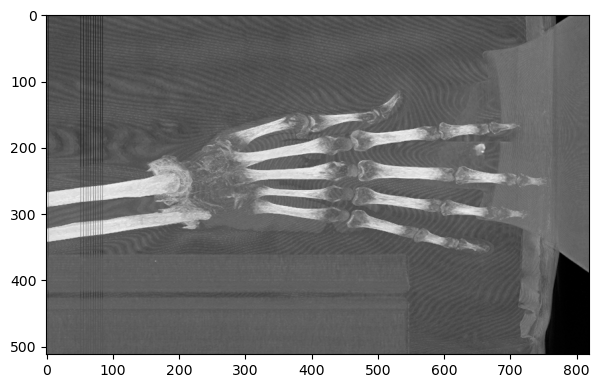

In [36]:
# Создание изображения
plt.figure(figsize=(7, 7))
plt.imshow(projection_xpp, cmap='gray')

# Сохранение изображения в файл .png
plt.savefig('image1.png', bbox_inches='tight')

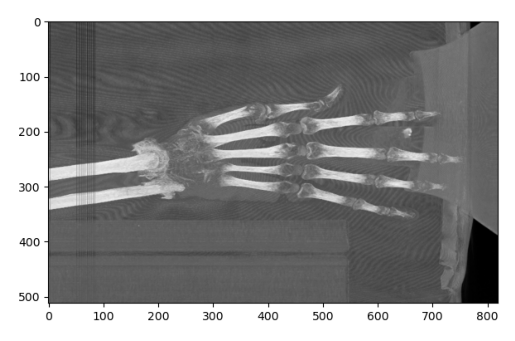

In [37]:
image7 = mpimg.imread('image1.png') # ОТКРЫТИЕ массива
plt.imshow(image7, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image7) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

#### 5.2 создание и сохранение контрастного изображения

In [38]:
image22 = Image.open('image1.png')
                
enhancer = ImageEnhance.Contrast(image22) # Создание объекта для улучшения контрастности
enhanced_image = enhancer.enhance(3.5) # Увеличение контрастности в 2 раза
enhanced_image.save('image1_contrast.png')

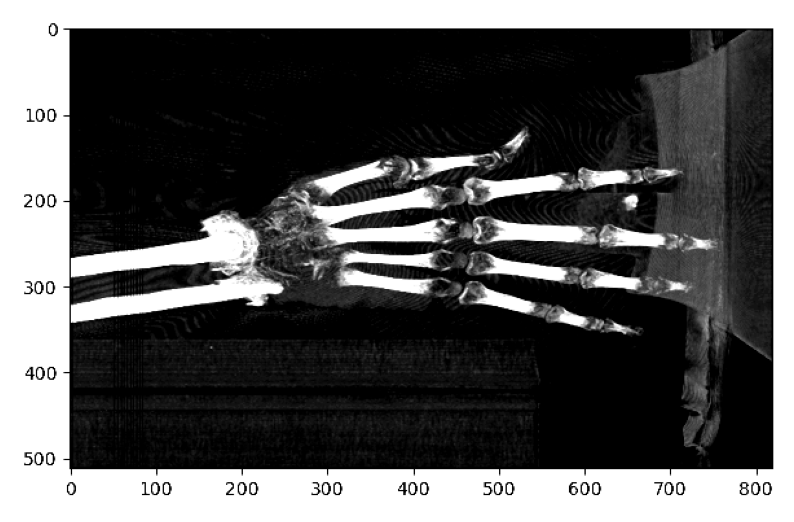

In [39]:
plt.figure(figsize=(10, 10))
image71 = mpimg.imread('image1_contrast.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

# 6. Поворот изображения с дискретной регулировкой и сеткой для возможного построения углов

In [56]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk

# Путь к изображению
image_path = 'image1_contrast.png'

class ImageRotatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Rotator")

        # Load image
        self.original_image = Image.open(image_path)
        self.current_image = self.original_image
        
        # Create Canvas
        self.canvas = tk.Canvas(root, width=self.current_image.width, height=self.current_image.height)
        self.canvas.pack()
        self.draw_grid()

        # Display initial image
        self.display_image(self.current_image)

        # Create Scale for rotation
        self.rotation_scale = tk.Scale(root, from_=0, to=-180, orient=tk.HORIZONTAL, length=400, 
                                       label="Rotate Image", command=self.rotate_image, resolution=1)
        self.rotation_scale.pack()

        # Button to save the current image
        self.save_button = tk.Button(root, text="Save Image", command=self.save_image)
        self.save_button.pack()

    def draw_grid(self):
        # Draw vertical and horizontal lines to create a grid
        grid_spacing = 50
        for i in range(0, self.canvas.winfo_width(), grid_spacing):
            self.canvas.create_line([(i, 0), (i, self.canvas.winfo_height())], tag='grid_line', fill="gray", dash=(2, 2))
        
        for i in range(0, self.canvas.winfo_height(), grid_spacing):
            self.canvas.create_line([(0, i), (self.canvas.winfo_width(), i)], tag='grid_line', fill="gray", dash=(2, 2))

    def display_image(self, image):
        # Resize the window to fit the image
        self.root.geometry(f"{image.width}x{image.height + 100}")  # Add some extra height for the controls

        # Convert Image to ImageTk
        self.tk_image = ImageTk.PhotoImage(image)
        self.canvas.config(width=image.width, height=image.height)
        self.canvas.create_image(image.width//2, image.height//2, image=self.tk_image)

    def rotate_image(self, angle):
        angle = int(angle)
        self.current_image = self.original_image.rotate(-angle, expand=True)
        self.display_image(self.current_image)
        
        # Redraw the grid after displaying the rotated image
        self.canvas.delete('grid_line')
        self.draw_grid()

    def save_image(self):
        file_path = filedialog.asksaveasfilename(defaultextension=".png",
                                                 filetypes=[("PNG files", "*.png"), ("All files", "*.*")])
        if file_path:
            self.current_image.save(file_path)
            messagebox.showinfo("Image Saved", f"Image saved as {file_path}")

# Main
root = tk.Tk()
app = ImageRotatorApp(root)
root.mainloop()

## Изображение вращается в том числе для удобства наблюдения и, возможно, построения ОСЕЙ

### Ориентация костей предплечья - вертикальная

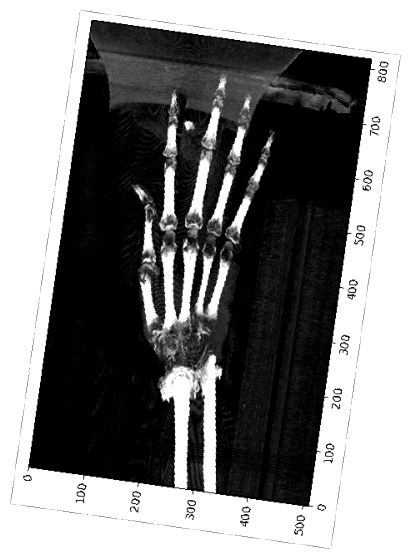

In [40]:
plt.figure(figsize=(7, 7))
image711 = mpimg.imread('image1_contrast_vertical.png') # ОТКРЫТИЕ массива
plt.imshow(image711, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image711) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

# 7. Поворот X и Y плоскостей вокруг оси Z для получения проекций с заданным углом поворота

# Получить пару проекций  "projection_x / projection_x"  повёрнутую на угол (любой угол от -180 до +180 ) вокруг оси Z относительно "нормального", или первичного положения с сохранением угла 90 градусов между плоскостями X и Y для возможности взглянуть "НЕМНОГО СО СТОРОНЫ"

### 7.1 кисть в горизонтальном (лежачем) положении  c углом поворота 45 градусов

Original volume shape: (512, 512, 819)
Rotated volume shape: (512, 512, 819)


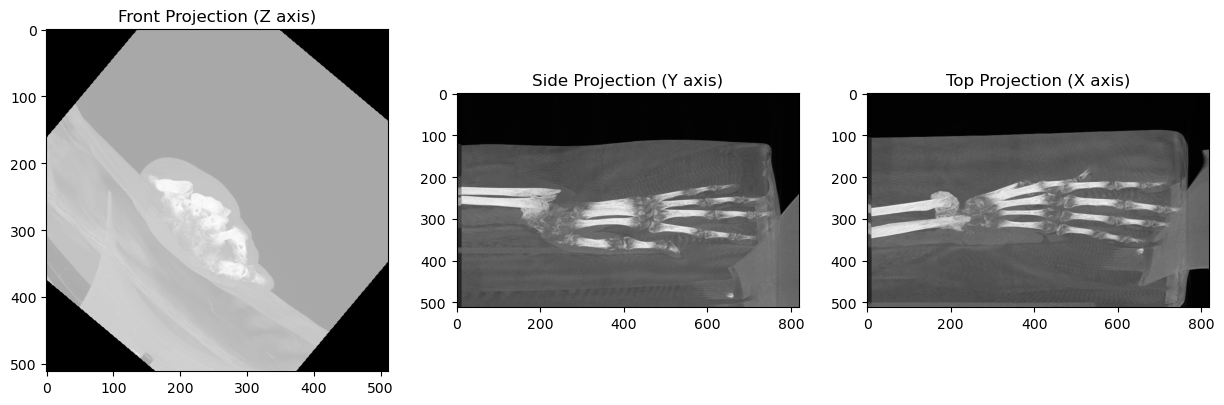

In [41]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(0, 1), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'unhealthy1'

# Чтение и нормализация изображения
volume = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume.shape)

# Угол поворота (например, 30 градусов)
angle = 40

# Поворот объёма вокруг оси Z
rotated_volume = rotate_volume(volume, angle)
print("Rotated volume shape:", rotated_volume.shape)

# Получение проекций после поворота
projection_xx, projection_yy, projection_zz = get_projections(rotated_volume)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_zz, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_yy, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_xx, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


#### 7.2 Проверка значений в массиве по координатам

In [42]:
projection_xx[150][150]

8477

In [43]:
projection_xx[150][400]

8373

In [44]:
projection_xx[275][100]

10512

#### 7.3 Расчёты для преобразования в стандартные значения пикселей

In [45]:
print(projection_xx.max())
print(projection_xx.min())
print(projection_xx.mean())

10988
7193
8392.678259023962


In [46]:
# разность значений
pp = projection_xx.max() - projection_xx.min()
pp

3795

In [47]:
# Соотношение значений пикселей
ss = int(pp / 256 + 1)
ss

15

In [48]:
# приведённый массив "с нулями в минимуме"
projection_xxp = projection_xx - 7193
projection_xxp

array([[   2,    3,    2, ...,   26,   31,   28],
       [   2,    2,    2, ...,   30,   40,   37],
       [   3,    2,    2, ...,   30,   26,   56],
       ...,
       [1366, 1366, 1366, ...,   33,   38,   30],
       [1362, 1361, 1361, ...,   50,   31,   40],
       [1363, 1364, 1360, ...,   32,   32,   48]], dtype=uint16)

In [49]:
# приведённый массив к размерности .png
projection_xxpp = np.floor(projection_xxp / ss) # ceil
projection_xxpp

array([[ 0.,  0.,  0., ...,  1.,  2.,  1.],
       [ 0.,  0.,  0., ...,  2.,  2.,  2.],
       [ 0.,  0.,  0., ...,  2.,  1.,  3.],
       ...,
       [91., 91., 91., ...,  2.,  2.,  2.],
       [90., 90., 90., ...,  3.,  2.,  2.],
       [90., 90., 90., ...,  2.,  2.,  3.]])

In [50]:
print(projection_xxpp.max())
print(projection_xxpp.min())
print(projection_xxpp.mean())

253.0
0.0
79.51348824786325


#### 7.4 Изображения - в ".png"

##### сохранение обычного изображения и вывод на экран БЕЗ ДОПОЛНИТЕЛЬНОЙ РАМКИ

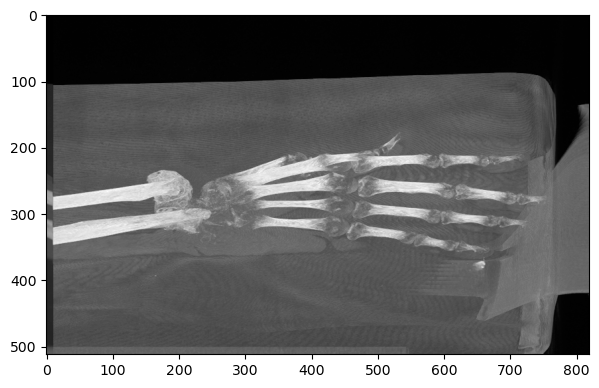

In [51]:
# Создание изображения
plt.figure(figsize=(7, 7))
plt.imshow(projection_xxpp, cmap='gray')

# Сохранение изображения в файл .png
plt.savefig('image2.png', bbox_inches='tight')

##### создание и сохранение контрастного изображения

In [52]:
image9 = Image.open('image2.png')
                
enhancer = ImageEnhance.Contrast(image9) # Создание объекта для улучшения контрастности
enhanced_image9 = enhancer.enhance(3.7) # Увеличение контрастности в 2 раза
enhanced_image9.save('image2_contrast.png')

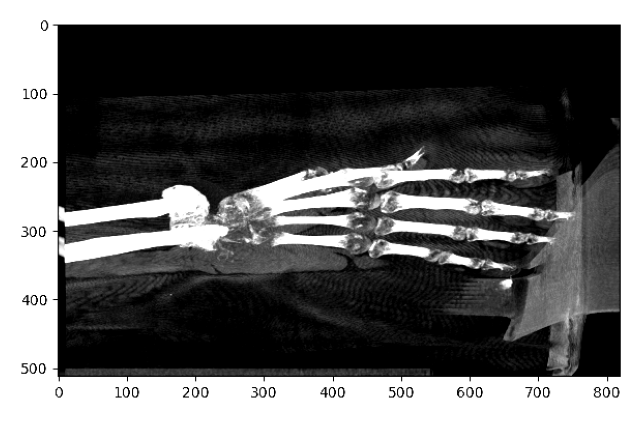

In [53]:
plt.figure(figsize=(8, 8))
image91 = mpimg.imread('image2_contrast.png') # ОТКРЫТИЕ массива
plt.imshow(image91, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image91) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

#### 7.5 Поворот изображения с дискретной регулировкой и сеткой для возможного построения углов

In [57]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk

# Путь к изображению
image_path = 'image2_contrast.png'

class ImageRotatorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Rotator")

        # Load image
        self.original_image = Image.open(image_path)
        self.current_image = self.original_image
        
        # Create Canvas
        self.canvas = tk.Canvas(root, width=self.current_image.width, height=self.current_image.height)
        self.canvas.pack()
        self.draw_grid()

        # Display initial image
        self.display_image(self.current_image)

        # Create Scale for rotation
        self.rotation_scale = tk.Scale(root, from_=0, to=-180, orient=tk.HORIZONTAL, length=400, 
                                       label="Rotate Image", command=self.rotate_image, resolution=1)
        self.rotation_scale.pack()

        # Button to save the current image
        self.save_button = tk.Button(root, text="Save Image", command=self.save_image)
        self.save_button.pack()

    def draw_grid(self):
        # Draw vertical and horizontal lines to create a grid
        grid_spacing = 50
        for i in range(0, self.canvas.winfo_width(), grid_spacing):
            self.canvas.create_line([(i, 0), (i, self.canvas.winfo_height())], tag='grid_line', fill="gray", dash=(2, 2))
        
        for i in range(0, self.canvas.winfo_height(), grid_spacing):
            self.canvas.create_line([(0, i), (self.canvas.winfo_width(), i)], tag='grid_line', fill="gray", dash=(2, 2))

    def display_image(self, image):
        # Resize the window to fit the image
        self.root.geometry(f"{image.width}x{image.height + 100}")  # Add some extra height for the controls

        # Convert Image to ImageTk
        self.tk_image = ImageTk.PhotoImage(image)
        self.canvas.config(width=image.width, height=image.height)
        self.canvas.create_image(image.width//2, image.height//2, image=self.tk_image)

    def rotate_image(self, angle):
        angle = int(angle)
        self.current_image = self.original_image.rotate(-angle, expand=True)
        self.display_image(self.current_image)
        
        # Redraw the grid after displaying the rotated image
        self.canvas.delete('grid_line')
        self.draw_grid()

    def save_image(self):
        file_path = filedialog.asksaveasfilename(defaultextension=".png",
                                                 filetypes=[("PNG files", "*.png"), ("All files", "*.*")])
        if file_path:
            self.current_image.save(file_path)
            messagebox.showinfo("Image Saved", f"Image saved as {file_path}")

# Main
root = tk.Tk()
app = ImageRotatorApp(root)
root.mainloop()

##### Ориентация костей предплечья - вертикальная

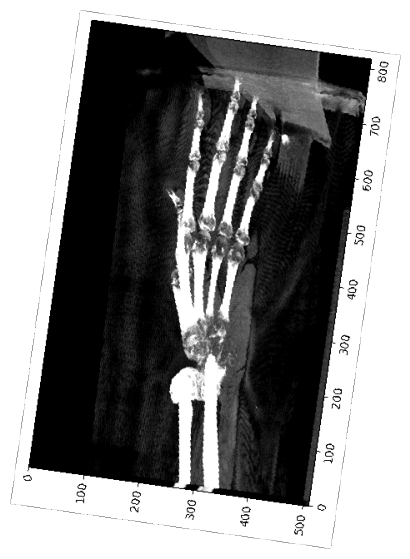

In [55]:
plt.figure(figsize=(7, 7))
image99 = mpimg.imread('image2_contrast_vertical.png') # ОТКРЫТИЕ массива
plt.imshow(image99, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image99) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()